# Image Collection Recommendation Analysis
This analysis evaluates different feature spaces for use in image recommendation when the topic is already controlled for. In this case, we use 20 different categories. Images for each category are found by searching that category term and selecting the top 10 image collections that are returned. Each collection is curated by an individual. For each collection, we then download up to 200 images. This totals 26,216 images.

Now that we have the imagery, we perform the following process for each image. 
1. Let this image be called the "left out" image
2. Let the collection where the image came from be called the "query" collection
3. Let the category of the query collection be called the "target category"
4. Remove the left out image from the query collection.
5. Gather all the images from collections in the target category except those from the query collection. Call this group of images the "corpus"
6. Add the left out image to the corpus
7. Use the images left in the query collection in order to rank the images in the corpus. In our first pass case, we will just use the minimum euclidean distance between an image in the corpus and those in the query collection.
8. Record the rank of the left out image in this ordering

The key metric we are going to look at is this rank divided by the number of images in the corpus, so that it is normalized for each query. Note that a random ordering metric will be 50%.

In this analysis, we look at both the valence image space and the space created using the features from the final layer of the Inception-v3 network trained on ImageNet. We then also evaluate combining the two feature spaces. This allows us to evaluate the hypothesis that the Inception network will do a better job finding appropriate images because of the underlying objects in the scenes, whereas the valence space will do better identifying appropriate images based on style-like features.

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os.path
import pandas as pd
from PIL import Image
import sklearn
import scipy.spatial
import scipy.stats

In [23]:
def prep_data(data):
    idx = pd.MultiIndex.from_tuples(
        [(x.partition('/')[0], x.split('/')[1], '/'.join(x.split('/')[1:3]), x.rpartition('/')[2]) 
         for x in data.columns], 
        names=['category', 'user', 'group', 'image'])
    
    data = data.T.set_index(idx).sort_index()
    return data

In [24]:
# This opens a pandas matrix with columns as feature values and rows as images. 
valence_features = pd.read_pickle('/data/neon/customer_images/image_collections/10_categories/20_categories_valence.pkl')
valence_features = prep_data(valence_features)
inception_features = pd.read_pickle('/data/neon/customer_images/image_collections/10_categories/20_categories_inception.pkl')
inception_features = prep_data(inception_features)

In [25]:
def find_leftout_rank_for_single_category(features, category, search_func, group=None):
    '''Returns the rank of the leftout image for all images in a single category
    
    Search function is one that takes (query, corpus) where query is a vector and corpus is a 
    pandas matrix where the columns are features and rows are entries. 
    
    Returns a pandas DataFrame where the index is the same as the rows in the corpus and 
    the columns are the rank in the corpus and the size of the corpus.
    '''
    ranks = []
    features = features.sort_index()
    features = features.xs(category, level='category', drop_level=False)
    
    # Create a matrix of pairwise distances for all the images in this category
    dists = pd.DataFrame(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(features)),
                         index=features.index, columns=features.index)
    sample_pool = dists
    if group:
        sample_pool = dists.xs(group, level='group', drop_level=False)
    
    for key, left_out in sample_pool.iterrows():
        # generate a matrix where the rows are from the query group and the columns are from the corpus
        # (all the other groups plust the image that was pulled out)
        query_group = dists.loc[(slice(None), key[1], slice(None)),:]
        query_group = query_group.drop([key])
        corpus_dists = query_group.drop(query_group.index, axis=1)
        
        # Rank where the left out image would be returnd
        search_ranks = search_func(corpus_dists)
        ranks.append(pd.Series({'rank' : search_ranks[key],
                                'size': corpus_dists.shape[1]},
                               name=key))
    
    idx = pd.MultiIndex.from_tuples([x.name for x in ranks], names=features.index.names)
    return pd.DataFrame(ranks, index=idx)
        
    return pd.Series({'mean' : ranks['rank'].mean(),
                      'std': ranks['rank'].std(),
                      'top20': (ranks['rank'] < 20).sum()/float(ranks.shape[0]),
                      'top50' : (ranks['rank'] < 50).sum()/float(ranks.shape[0]),
                      'mean_frac': (ranks['rank']/ranks['size']).mean(),
                      'std_frac' : (ranks['rank']/ranks['size']).std()})

In [26]:
def random_search_func(corpus_dists):
    '''Randomly ranks the entries in the corpus'''
    ranks = np.arange(len(corpus_dists.columns)) + 1
    np.random.shuffle(ranks)
    return pd.Series(ranks, index=corpus_dists.columns)

In [27]:
def min_dist_rank_func(corpus_dists):
    return corpus_dists.min(axis=0).rank(method='min')

In [28]:
def mean_dist_rank_func(corpus_dists):
    return corpus_dists.mean(axis=0).rank(method='min')

In [29]:
def l2_dist_search_func(query, corpus):
    '''Ranks entries by their L2 distance to the query'''
    dists = corpus.apply(lambda x: np.linalg.norm(x-query), axis=1)
    return dists.rank(method='min')

In [30]:
def estimate_leftout_rank_for_two_feature_types(features_a, features_b, w_b, category, 
                                                search_func, group=None):
    features = pd.concat([features_a, w_b * features_b], axis=1)
    return find_leftout_rank_for_single_category(features, category, search_func, group)

In [109]:
def show_image_grid(df, rows=4, cols=5, 
                    base_dir='/data/neon/customer_images/image_collections/10_categories'):
    '''Plot first images from a DataFrame in a grid. 
    
    Takes the index of the DataFrame to identify the images to display
    '''
    fig = plt.figure(2, (cols*4, rows*4))
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols))
    i = 0
    for row in df.index.tolist():
        canvas = Image.new("RGB", (150,200), "white")
        im = Image.open(os.path.join(base_dir, row[0], row[2], row[3]))
        im.thumbnail((200, 200))
        #canvas.paste(im, im.getbbox())
        grid[i].imshow(im)
        grid[i].set_xlim(0., 200.)
        grid[i].set_ylim(200., 0.)
        grid[i].axes.get_xaxis().set_ticks([])
        grid[i].axes.get_yaxis().set_ticks([])
        i += 1
        if i >= (rows*cols):
            break
    plt.show()

## Combining Valence and Inception Feature Spaces
In this analysis, we want to test the hypothesis that valence features adds aditional useful information to the inception features. So, we can do a simplistic combining of the feature spaces by just concatenating them and scaling the Inception feature space to be on an appropriate scale with the valence space.  To find the scale factor, we use a subset of the categories and try a range of weights to find one near the best resulting average rank and use that for later experiments.

If we were to optimize this process for a production setting, we would concatenate the feature vectors and then learn a small network ontop of all the features. This network would be trained using examples of this task.

In [31]:
def find_best_feature_balance(features_a, features_b):
    stats = []
    w_samples = np.logspace(-2, -1, 20)
    for w_b in w_samples:
        cur_stats = {}
        for category in valence_features.index.get_level_values('category').unique():
            res = estimate_leftout_rank_for_two_feature_types(features_a, features_b, 
                                                              w_b, category, min_dist_rank_func)
            cur_stats[category] = (res['rank']/res['size']).mean()
        stats.append(pd.Series(cur_stats, name=w_b))
    return pd.DataFrame(stats)
#comb_stats = find_best_feature_balance(valence_features.ix[:,0:100], inception_features)
comb_stats

cake      dogs    hiking  italian recipes   nursery  sailboat  \
0.010000  0.407779  0.429168  0.371494         0.338890  0.391231  0.411073   
0.011288  0.405146  0.426474  0.368202         0.339823  0.389633  0.404053   
0.012743  0.402735  0.423504  0.364428         0.341541  0.388189  0.397488   
0.014384  0.400188  0.419849  0.360140         0.343692  0.386989  0.391578   
0.016238  0.398388  0.416160  0.355780         0.345562  0.385392  0.386418   
0.018330  0.397162  0.412852  0.353001         0.348229  0.384120  0.380352   
0.020691  0.396231  0.410467  0.351013         0.351169  0.382758  0.374392   
0.023357  0.396020  0.407992  0.350052         0.354327  0.381628  0.369270   
0.026367  0.396489  0.406717  0.350066         0.357148  0.380295  0.364138   
0.029764  0.397366  0.405784  0.350995         0.360332  0.379473  0.360037   
0.033598  0.397931  0.405203  0.352050         0.363924  0.378691  0.357316   
0.037927  0.397698  0.404782  0.353105         0.367508  0.378651  0.355962   
0.042813  0.397646  0.404731  0.353767         0.371181  0.378825  0.355518   
0.048329  0.397754  0.404656  0.354012         0.374931  0.379243  0.354750   
0.054556  0.397518  0.404394  0.354330         0.378499  0.379589  0.354719   
0.061585  0.396994  0.404779  0.354995         0.381942  0.379864  0.354286   
0.069519  0.397379  0.404808  0.355648         0.385364  0.380246  0.355093   
0.078476  0.397903  0.404746  0.356809         0.388610  0.381019  0.356335   
0.088587  0.398456  0.404940  0.357653         0.391240  0.381403  0.358214   
0.100000  0.399053  0.405283  0.358422         0.393043  0.381959  0.359427   

            spring  spring dress    travel  woodworking  
0.010000  0.387737      0.274053  0.333473     0.386147  
0.011288  0.379865      0.270233  0.328572     0.382932  
0.012743  0.371790      0.267664  0.323846     0.379825  
0.014384  0.364303      0.264714  0.319475     0.376668  
0.016238  0.355808      0.262400  0.315473     0.374101  
0.018330  0.347974      0.261029  0.311312     0.371971  
0.020691  0.340063      0.259692  0.307282     0.370500  
0.023357  0.333077      0.258785  0.304080     0.368653  
0.026367  0.326900      0.258171  0.301933     0.367368  
0.029764  0.321690      0.257688  0.301314     0.366027  
0.033598  0.317161      0.257635  0.302439     0.364979  
0.037927  0.313438      0.257367  0.303714     0.364138  
0.042813  0.310380      0.256955  0.305365     0.364150  
0.048329  0.308135      0.256893  0.307351     0.364443  
0.054556  0.306956      0.257130  0.309705     0.365030  
0.061585  0.306555      0.257294  0.311956     0.365797  
0.069519  0.305917      0.257470  0.314568     0.366537  
0.078476  0.305576      0.257636  0.316973     0.367540  
0.088587  0.304610      0.257927  0.319446     0.368471  
0.100000  0.303944      0.257713  0.321750     0.369779

In [32]:
comb_stats.mean(axis=1)

0.010000    0.373105
0.011288    0.369493
0.012743    0.366101
0.014384    0.362760
0.016238    0.359548
0.018330    0.356800
0.020691    0.354357
0.023357    0.352389
0.026367    0.350922
0.029764    0.350071
0.033598    0.349733
0.037927    0.349636
0.042813    0.349852
0.048329    0.350217
0.054556    0.350787
0.061585    0.351446
0.069519    0.352303
0.078476    0.353315
0.088587    0.354236
0.100000    0.355037
dtype: float64

## Finding all the image ranks

In this block, we determine the rank of the left out image for every image in the collection for the three different feature spaces (valence, Inception, valence+Inception). Note that the valence space has been through PCA, so for efficiency, when combining the feature spaces, we only use the top 100 features.

In [33]:
ranks = []
for category in valence_features.index.get_level_values('category').unique():
    cat_ranks = {
                'valence_min' : find_leftout_rank_for_single_category(
                    valence_features, category, min_dist_rank_func),
                'inception_min' : find_leftout_rank_for_single_category(
                    inception_features, category, min_dist_rank_func),
                'incep_val_min' : estimate_leftout_rank_for_two_feature_types(
                    valence_features.ix[:,0:100], inception_features, 
                    0.035, category, min_dist_rank_func)
            }
    cat_ranks = pd.concat(cat_ranks.itervalues(), axis=1, keys=cat_ranks.iterkeys())
    ranks.append(cat_ranks)
incep_val_ranks = pd.concat(ranks, axis=0)
incep_val_ranks

valence_min  \
                                                                                                                rank   
category             user         board                             image                                              
abstract photography 10sopeachy   10sopeachy/abstract-photography   0058c36036c723b075d32572ac934c56.jpg       535.0   
                                                                    0804df6d1768a6b04109bc8669818f72.jpg       640.0   
                                                                    3f60442da5ca1ff80b6f8b3819c52f34.jpg       428.0   
                                                                    42486c111f9298a97b569b7e69d20cd3.jpg       719.0   
                                                                    482bbb8f12605af6931ea6b848b00d75.jpg       641.0   
                                                                    4f1b5ee47736c4dda74a85a66c1f9565.jpg       562.0   
                                                                    9e7361a0367a373d5995a8bf58d02d2d.jpg       463.0   
                                                                    9ff5955bb892d51cb4d81985253cd3d1.jpg       529.0   
                                                                    a156f8a6f4ff05df77d349d82f6ac902.jpg       998.0   
                                                                    af90a91f9a1bf9ee7c0e877b7a64551c.jpg       263.0   
                                                                    c41129ab97bf3104e004c51c50a37574.jpg       376.0   
                                                                    f8cb4931cc084ffc8cec58a0dd1be4ab.jpg       422.0   
                                                                    fb3e97dbf8550fa7d2f20895bdba63c1.jpg       262.0   
                                                                    fc83f3ba596c3d00b1f8f200061fe669.jpg       377.0   
                     ArtbyWietzie ArtbyWietzie/abstract-photography 00a016f7d0b9e25fc0e1fc958cc7383b.jpg       219.0   
                                                                    01237ccb1e7cb77e1e71bea1e81a9128.jpg       497.0   
                                                                    01aa03eb078413ab1fd84884e38b0cc3.jpg       510.0   
                                                                    02538ab0fb161c4deaa1f701b409b8ac.jpg       804.0   
                                                                    0289f0a496d08bbfd8aa6035a0e9b85f.jpg       644.0   
                                                                    0510f5558bb698a83d5326a2229bdab5.jpg       840.0   
                                                                    05d49586b31fefedf6cbcadd4a6331c1.jpg       183.0   
                                                                    060af51b6b21384d0d14f489b54bc074.jpg        17.0   
                                                                    0bffb9d752f0e00369e7959e538df27f.jpg       104.0   
                                                                    0e1873e871e74b78f72606d647ed880f.jpg       572.0   
                                                                    1009b42523f25e2793cbf3b3f11ec081.jpg       683.0   
                                                                    15f5026a7dd74af95b9b6442c64ea47c.jpg       705.0   
                                                                    1aa87344eff9c50939450d3a38dd6e36.jpg       662.0   
                                                                    20160ab6f76042305a14e467881de77a.jpg       817.0   
                                                                    2116abfc0316a50cff1030ed54ae8b65.jpg       543.0   
                                                                    23a437a85772b74e3dd49fc1bb314659.jpg       210.0   
...                                                                                                              ...   
woodworking          save

## Average Ranks per Category

Now, we look at the average rank of the left out image for each category under each feature space.

In [52]:
rank_swap = incep_val_ranks.swaplevel(0,1, axis=1).dropna()
incep_val_mean_frac = rank_swap['rank'] / rank_swap['size']
incep_val_mean_frac_category = incep_val_mean_frac.groupby(level='category').mean()
incep_val_mean_frac_category

valence_min  inception_min  incep_val_min
category                                                       
abstract photography     0.447834       0.304555       0.338603
cake                     0.430315       0.406146       0.397920
container gardening      0.356903       0.382979       0.361716
dogs                     0.446082       0.404474       0.404910
halloween                0.266953       0.250227       0.199407
hiking                   0.401353       0.368119       0.352383
hotrod                   0.455787       0.381107       0.394776
italian recipes          0.343168       0.404207       0.365127
makeup                   0.280152       0.249335       0.210742
nursery                  0.407249       0.384203       0.378578
paleo                    0.427877       0.445723       0.427611
sailboat                 0.459989       0.366029       0.356988
spring                   0.443702       0.302667       0.315893
spring dress             0.311715       0.268224       0.257511
stir fry                 0.361415       0.349095       0.331513
superbowl                0.467736       0.444569       0.445879
tattoos                  0.429837       0.394963       0.393066
travel                   0.379478       0.334770       0.302928
urban design             0.379206       0.323429       0.317391
woodworking              0.407892       0.378398       0.364526

## Average Rank for Each Feature Space

Now, we look at the overall average rank for each feature space and see that the Inception features are more effective at this task than valence features alone, but by combining the two feature spaces, we see more improvement. 

In [120]:
incep_val_mean_frac.mean()

valence_min      0.399131
inception_min    0.362047
incep_val_min    0.351811
dtype: float64

## Is it significant?
We see an ~1% improvement by adding valence features to the inception features, but is that significant? We can test for significance using a T-test on the ranks of all the images for each feature space. When we do that, we see that all of the differences are statistically significant with a P-value that is very small. 

In [51]:
scipy.stats.ttest_rel(incep_val_mean_frac['incep_val_min'], incep_val_mean_frac['inception_min'])

(-8.452542178119522, 2.996246293028506e-17)

In [121]:
scipy.stats.ttest_rel(incep_val_mean_frac['valence_min'], incep_val_mean_frac['inception_min'])

(16.578839990228914, 2.0378390802263507e-61)

In [125]:
# See if we are statistically significant even if we aggregate to each category first
scipy.stats.ttest_rel(incep_val_mean_frac_category['incep_val_min'], incep_val_mean_frac_category['inception_min'])

(-2.5486915279463234, 0.019613405460079565)

# Visual Check
Finally, let's visually look at some distinctive examples. In each case, we'll look at the images that had the biggest discrepancy in ranking between feature sets to get an idea of which types of images one feature set can characterize better than another feature set. We can see that the valence features make more effective recommendations in both natural scenes and images with a distinctive style, whereas the Inception features can more effectively characterize structural images.

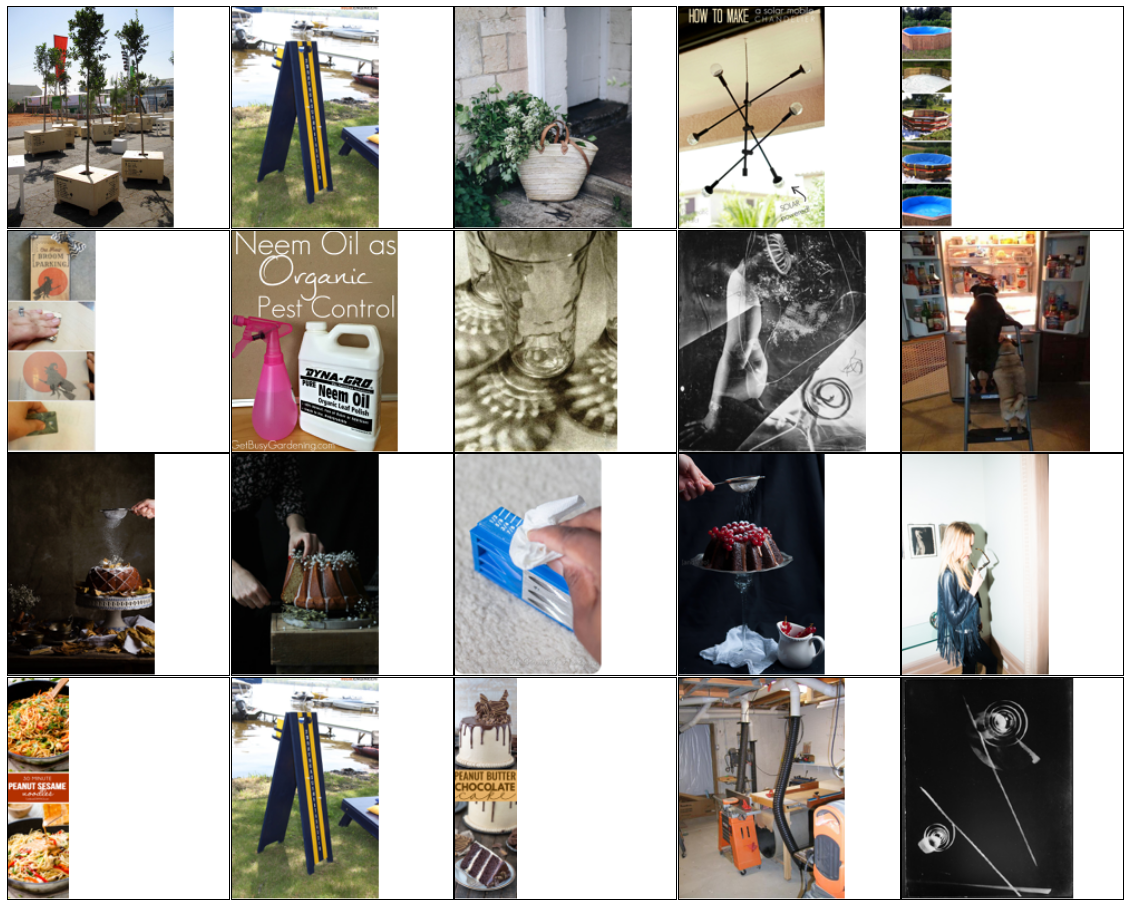

In [111]:
# Show the images that valence got right and Inception got wrong
rank_diff = (incep_val_mean_frac['valence_min'] - incep_val_mean_frac['inception_min']).sort_values()
show_image_grid(rank_diff)

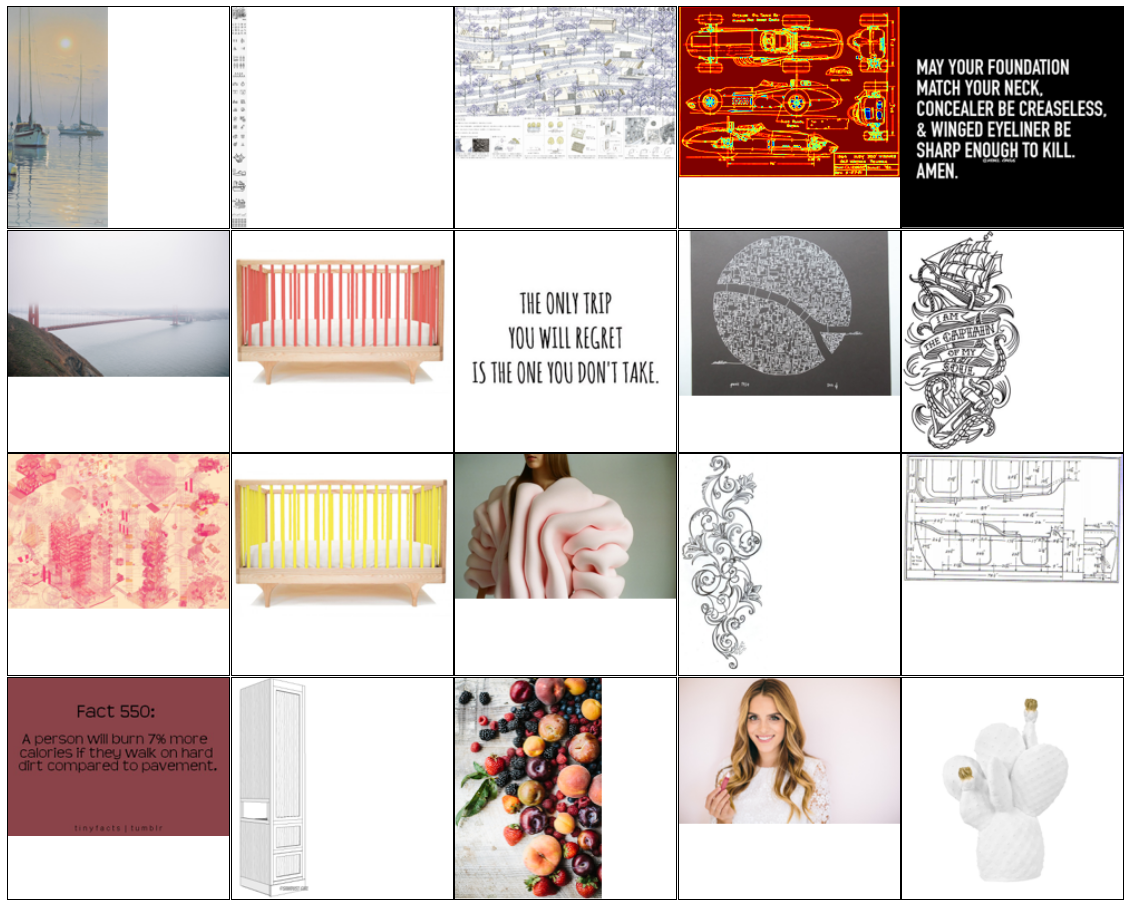

In [112]:
# Show the images that Inception got right and valence got wrong
rank_diff = (incep_val_mean_frac['valence_min'] - incep_val_mean_frac['inception_min']).sort_values(ascending=False)
show_image_grid(rank_diff)

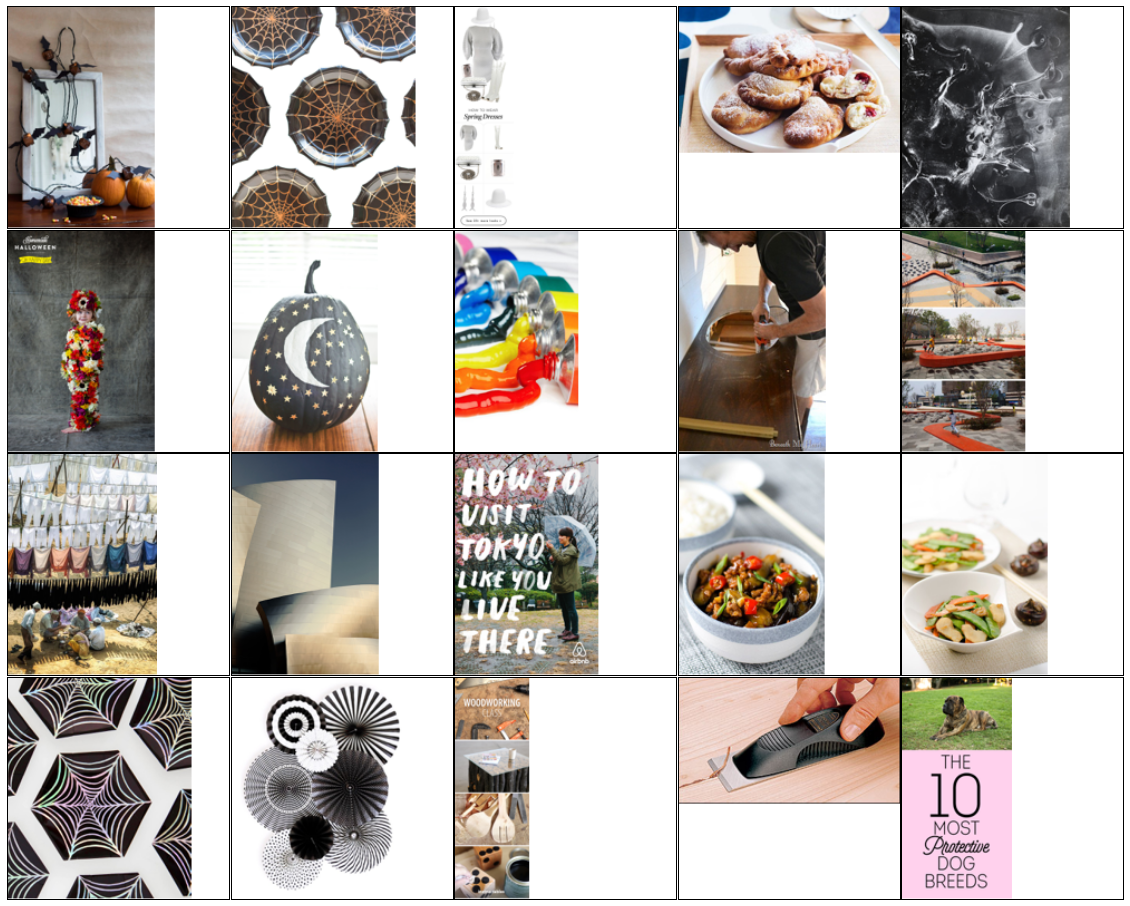

In [110]:
# Show the images that the combined valence+Inception got right and Inception by itself got wrong
rank_diff = (incep_val_mean_frac['incep_val_min'] - incep_val_mean_frac['inception_min']).sort_values()
show_image_grid(rank_diff)